In [ ]:
!pip install folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 9.1 MB/s eta 0:00:00


In [ ]:
# === Required Libraries from Assignment ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


import requests
from io import BytesIO
import os

import requests
import pandas as pd
from io import BytesIO

url = "https://data.insideairbnb.com/united-states/ny/new-york-city/2025-10-01/data/listings.csv.gz"
headers = {"User-Agent": "Mozilla/5.0"}

r = requests.get(url, headers=headers)

if r.status_code == 200:
    df = pd.read_csv(BytesIO(r.content), compression="gzip", low_memory=False)
    print("Loaded dataset shape:", df.shape)
else:
    print("Failed to load — status code:", r.status_code)



Loaded dataset shape: (36111, 79)


In [ ]:

# ============================================================
# TASK 1: Data Preparation and Exploration


# --- Basic selection & cleaning ---


# Price: remove $, commas, cast to float
if "price" in df.columns:
    df["price"] = (
        df["price"]
        .astype(str)
        .str.replace(r"[\$,]", "", regex=True)
        .astype(float)
    )

# Bathrooms from bathrooms_text if present
if "bathrooms_text" in df.columns:
    df["bathrooms"] = (
        df["bathrooms_text"]
        .astype(str)
        .str.extract(r"([0-9]*\.?[0-9]+)", expand=False)
        .astype(float)
    )

# Host response rate from text like "90%"
if "host_response_rate" in df.columns:
    df["host_response_rate_num"] = (
        df["host_response_rate"]
        .astype(str)
        .str.rstrip("%")
        .replace("nan", np.nan)
        .astype(float)
    )

# Host listings count (sometimes string)
if "host_listings_count" in df.columns:
    df["host_listings_count"] = pd.to_numeric(
        df["host_listings_count"], errors="coerce"
    )

# Numeric and categorical columns for analysis
numeric_cols = [
    "latitude",
    "longitude",
    "accommodates",
    "bathrooms",
    "bedrooms",
    "beds",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "review_scores_rating",
    "availability_365",
    "price",
    "host_response_rate_num",
    "host_listings_count",
]

categorical_cols = [
    "neighbourhood_group_cleansed",
    "neighbourhood_cleansed",
    "room_type",
    "property_type",
]

# Keep only existing ones
numeric_cols = [c for c in numeric_cols if c in df.columns]
categorical_cols = [c for c in categorical_cols if c in df.columns]

df = df[numeric_cols + categorical_cols].copy()
print("\nSubset used for analysis:")
df.info()

# --- Missing values ---

# Drop rows missing key fields
key_cols = [c for c in ["price", "latitude", "longitude", "room_type"] if c in df.columns]
df = df.dropna(subset=key_cols)

# Fill review-related numeric columns with median
for col in ["reviews_per_month", "review_scores_rating", "number_of_reviews"]:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# Fill structural features with median
for col in ["bathrooms", "bedrooms", "beds", "host_response_rate_num", "host_listings_count"]:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# Final drop if any NA remain
df = df.dropna()
print("\nAfter missing value handling:")
df.info()

# --- Features Derivation

# Numeric derived features
if {"accommodates", "bedrooms"}.issubset(df.columns):
    df["accommodates_per_bedroom"] = df["accommodates"] / (df["bedrooms"] + 0.1)

if "accommodates" in df.columns:
    df["price_per_person"] = df["price"] / (df["accommodates"] + 1e-6)

df_base = df.copy()

# One-hot encode categorical features for later classification
df_model = pd.get_dummies(df_base, columns=categorical_cols, drop_first=True)

print("\nData with engineered features (head):")
print(df_base.head())




Subset used for analysis:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36111 entries, 0 to 36110
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   latitude                      36111 non-null  float64
 1   longitude                     36111 non-null  float64
 2   accommodates                  36111 non-null  int64  
 3   bathrooms                     35892 non-null  float64
 4   bedrooms                      30162 non-null  float64
 5   beds                          21643 non-null  float64
 6   minimum_nights                36111 non-null  int64  
 7   number_of_reviews             36111 non-null  int64  
 8   reviews_per_month             24923 non-null  float64
 9   review_scores_rating          24923 non-null  float64
 10  availability_365              36111 non-null  int64  
 11  price                         21328 non-null  float64
 12  host_response_rate_num        203

In [ ]:
#  Interactive map of listings by price & neighborhood ---

# Sample subset for map
map_sample = df_base.sample(n=min(2000, len(df_base)), random_state=42)

center_lat = map_sample["latitude"].mean()
center_lon = map_sample["longitude"].mean()

m_price = folium.Map(location=[center_lat, center_lon], zoom_start=11)

if "neighbourhood_group_cleansed" in map_sample.columns:
    color_map = {
        name: color
        for name, color in zip(
            map_sample["neighbourhood_group_cleansed"].unique(),
            ["red", "blue", "green", "purple", "orange", "darkred", "lightred"],
        )
    }
else:
    color_map = {}

for _, row in map_sample.iterrows():
    neigh_group = row.get("neighbourhood_group_cleansed", "NA")
    color = color_map.get(neigh_group, "gray")
    tooltip = f"{neigh_group} | {row.get('room_type','')} | ${row['price']:.0f}"
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.6,
        popup=tooltip,
        tooltip=tooltip,
    ).add_to(m_price)

# Show this map in notebook by evaluating m_price
m_price

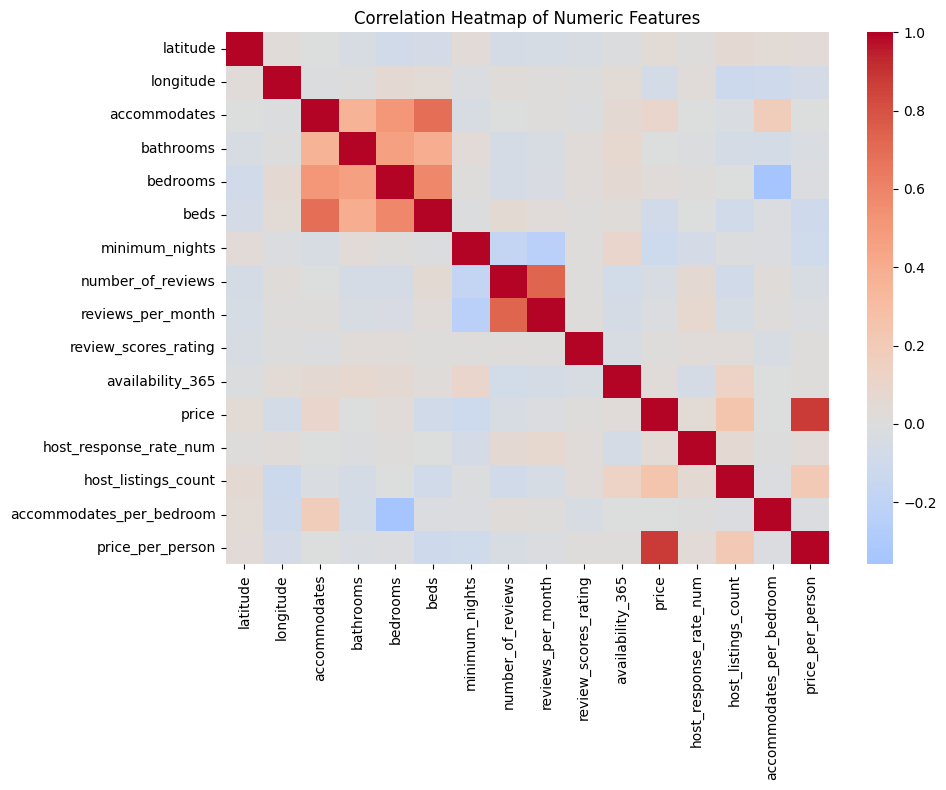

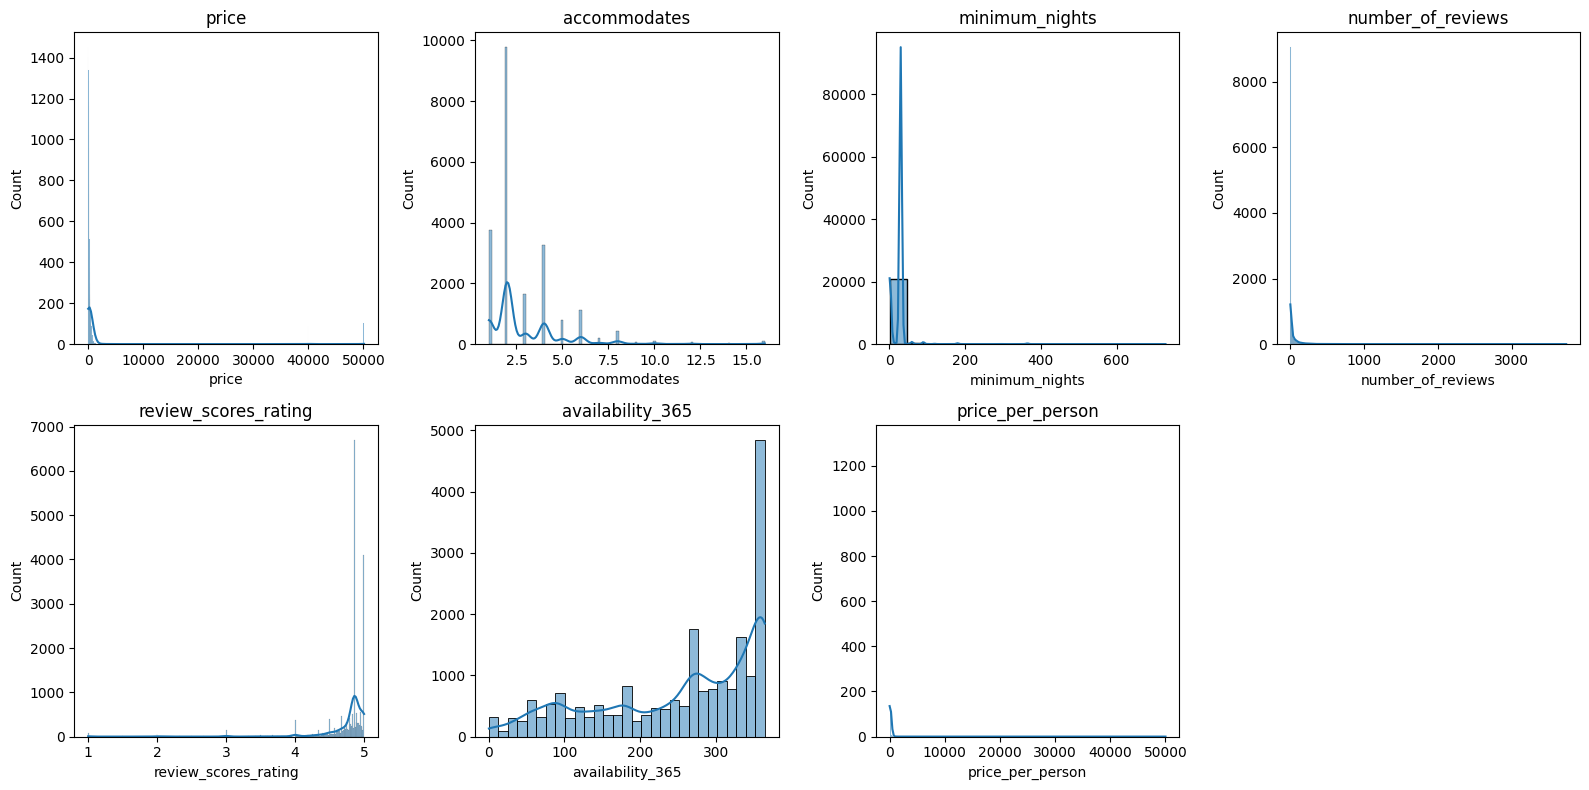

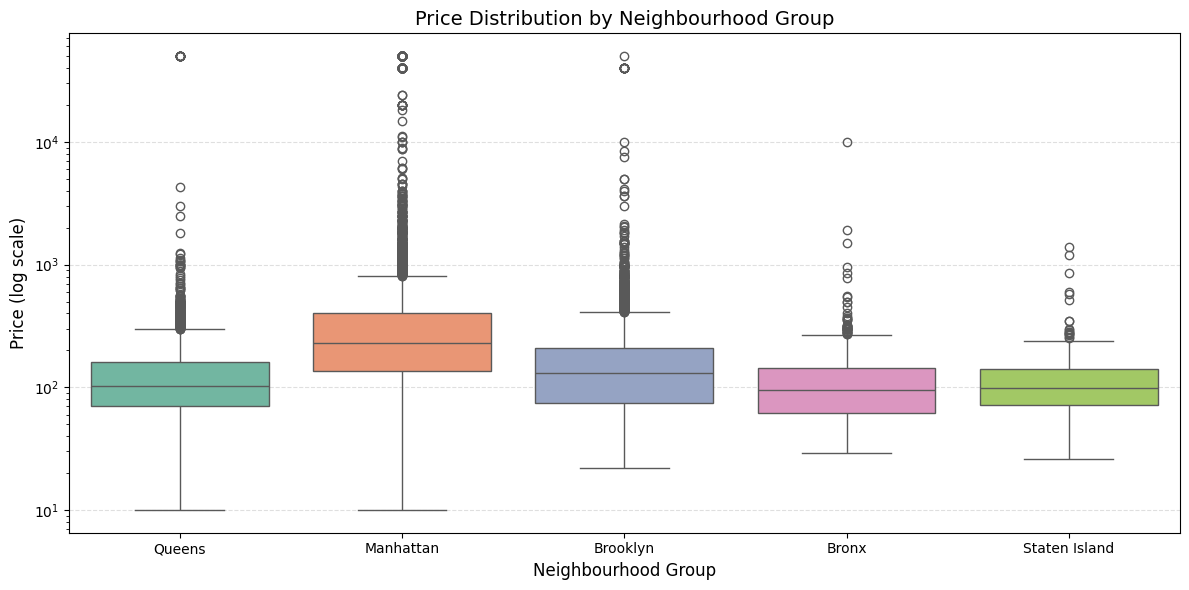

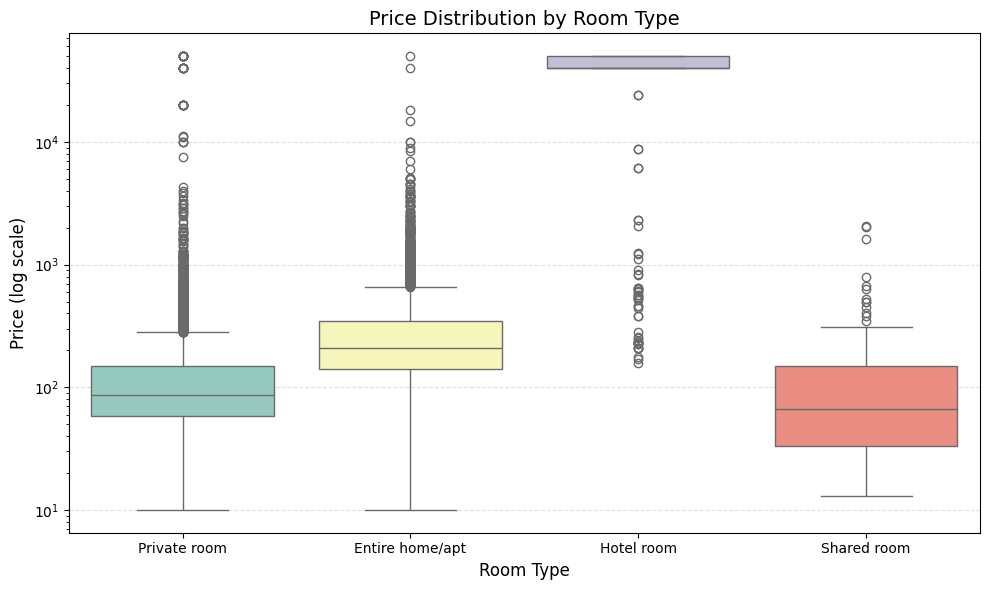


Standardized feature matrix shape: (21328, 15)


In [ ]:
# -- Correlation heatmap of numerical features ---

extra_numeric = ["accommodates_per_bedroom", "price_per_person"]
num_for_corr = [c for c in numeric_cols + extra_numeric if c in df_base.columns]

plt.figure(figsize=(10, 8))
corr = df_base[num_for_corr].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

# --- 1.6 Distributions of key metrics ---

plot_cols = [
    c
    for c in [
        "price",
        "accommodates",
        "minimum_nights",
        "number_of_reviews",
        "review_scores_rating",
        "availability_365",
        "price_per_person",
    ]
    if c in df_base.columns
]

fig, axes = plt.subplots(2, min(4, len(plot_cols)), figsize=(16, 8))
axes = axes.ravel()

for ax, col in zip(axes, plot_cols):
    sns.histplot(df_base[col], kde=True, ax=ax)
    ax.set_title(col)

# Turn off unused subplots
for ax in axes[len(plot_cols) :]:
    ax.axis("off")

plt.tight_layout()
plt.show()

# --- 1.7 Price patterns across neighborhoods and room types ---

# --- 1A: Price by Neighborhood Group ---
if "neighbourhood_group_cleansed" in df_base.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=df_base,
        x="neighbourhood_group_cleansed",
        y="price",
        hue = "neighbourhood_group_cleansed",
        legend = False,
        palette="Set2"
    )
    plt.yscale("log")
    plt.xlabel("Neighbourhood Group", fontsize=12)
    plt.ylabel("Price (log scale)", fontsize=12)
    plt.title("Price Distribution by Neighbourhood Group", fontsize=14)
    plt.grid(axis='y', linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


# --- 1B: Price by Room Type ---
if "room_type" in df_base.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=df_base,
        x="room_type",
        y="price",
        hue = "room_type",
        legend = False,
        palette="Set3"
    )
    plt.yscale("log")
    plt.xlabel("Room Type", fontsize=12)
    plt.ylabel("Price (log scale)", fontsize=12)
    plt.title("Price Distribution by Room Type", fontsize=14)
    plt.grid(axis='y', linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

# --- 1.8 Standardization for PCA & Outliers ---

numeric_predictors = [
    c
    for c in df_base.columns
    if c in numeric_cols + extra_numeric and c != "price"
]

X_num = df_base[numeric_predictors].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

print("\nStandardized feature matrix shape:", X_scaled.shape)



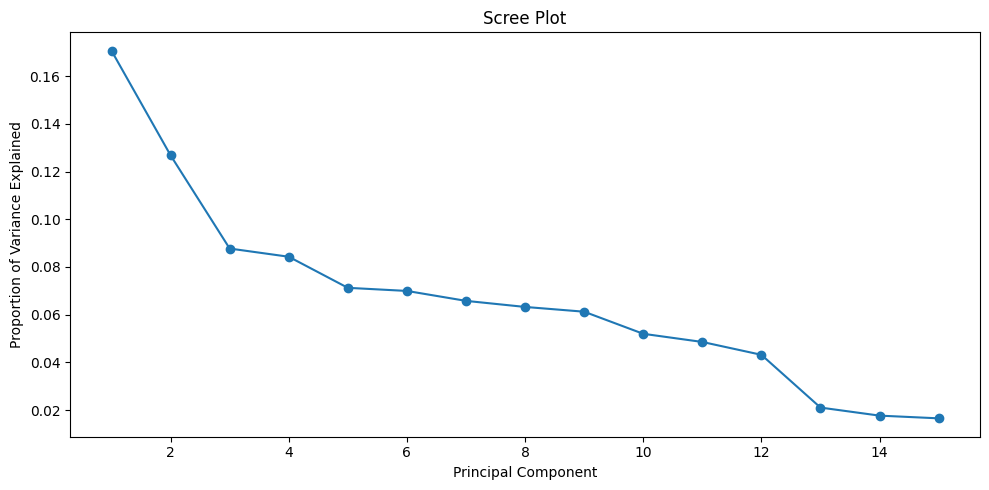

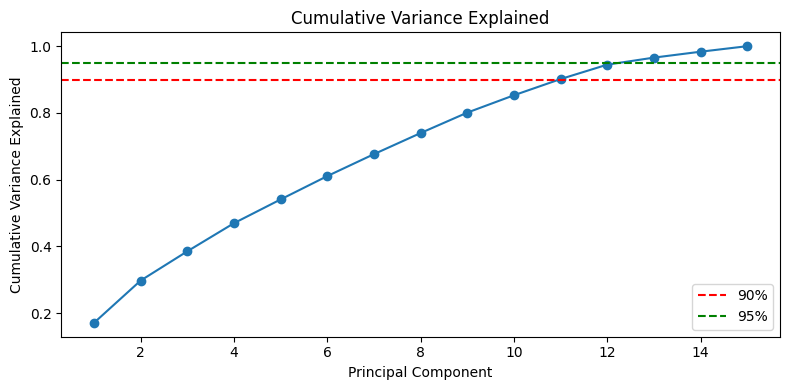


First 5 principal components loadings:
                               PC1       PC2       PC3       PC4       PC5
latitude                 -0.069870 -0.092151  0.118409  0.135484  0.134528
longitude                 0.046312  0.041585 -0.284368 -0.313076  0.263551
accommodates              0.496422  0.039565  0.124380  0.334293 -0.013288
bathrooms                 0.419122 -0.048551  0.023004 -0.031601 -0.002600
bedrooms                  0.517793 -0.033786  0.057486 -0.273537 -0.016512
beds                      0.530680  0.071250 -0.006947  0.144013 -0.029652
minimum_nights            0.008246 -0.314939 -0.248478  0.030937  0.166497
number_of_reviews        -0.019811  0.636338  0.007067 -0.022073  0.179626
reviews_per_month        -0.014313  0.642226  0.068545 -0.037910  0.184657
review_scores_rating      0.018019  0.023510  0.042228 -0.204833 -0.447572
availability_365          0.060348 -0.162122  0.134241 -0.020894  0.726439
host_response_rate_num   -0.007488  0.116720  0.215473 -0.11

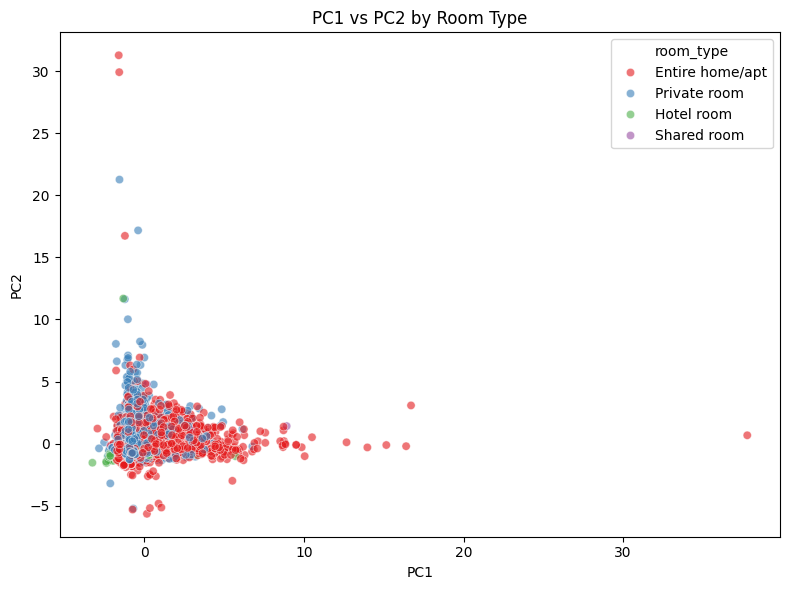

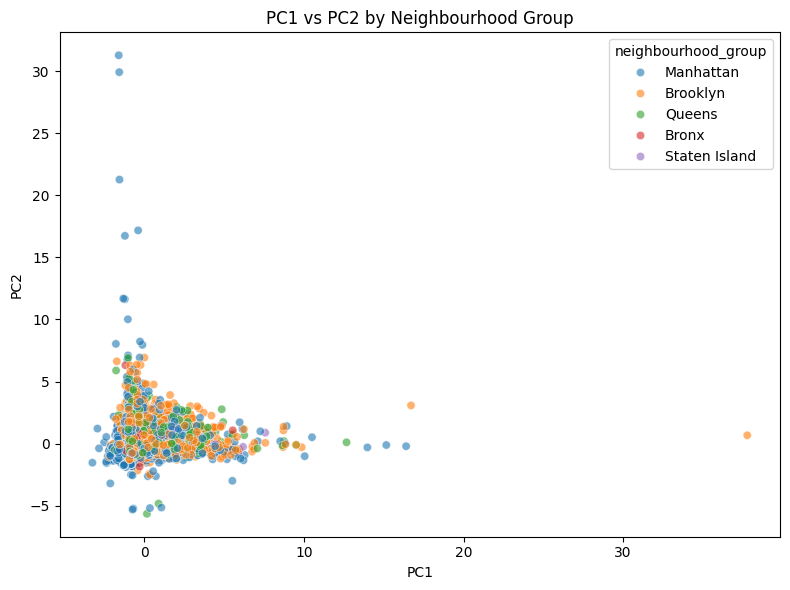

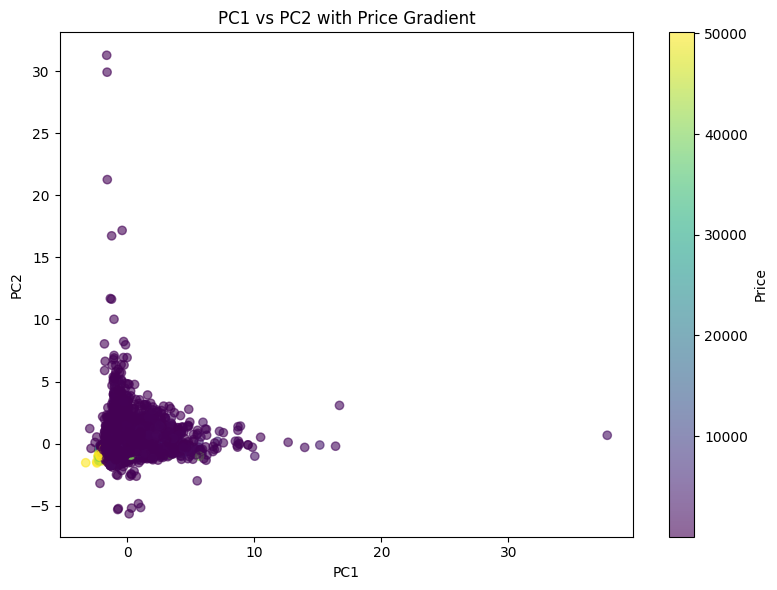

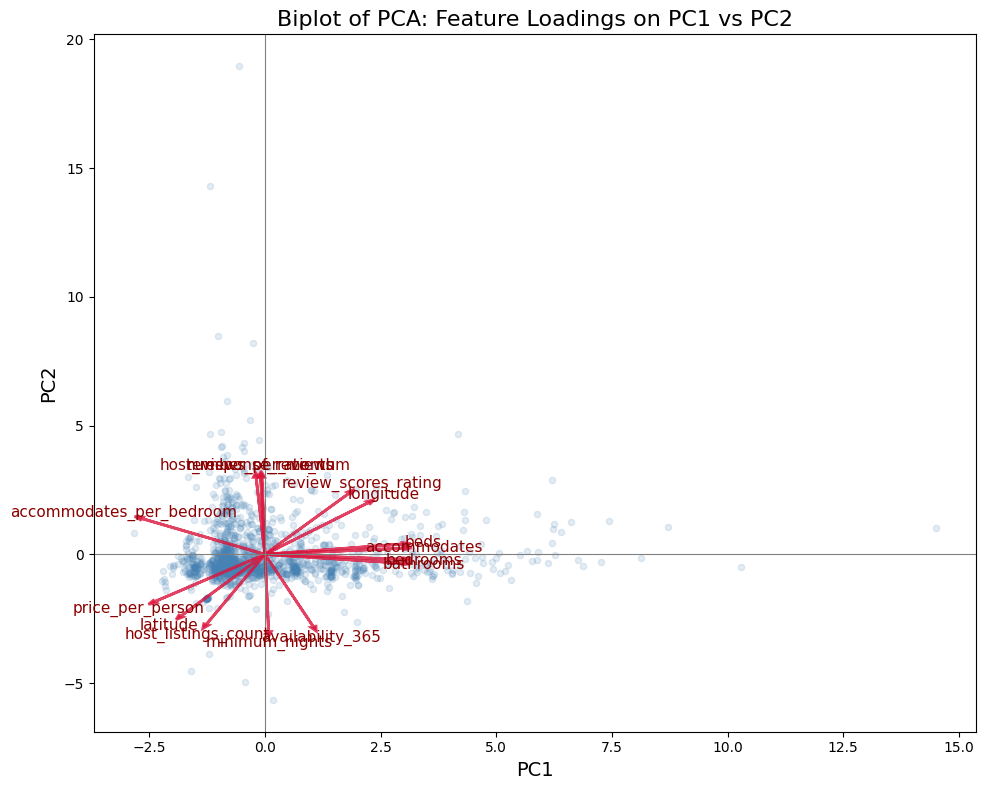

In [ ]:
# ============================================================
# TASK 2: Principal Component Analysis (PCA)
# ============================================================

# --- 2.1 PCA fit, scree plot, cumulative variance ---

pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

explained_var = pca_full.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_var) + 1), explained_var, marker="o")
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.title("Scree Plot")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cum_explained_var) + 1), cum_explained_var, marker="o")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Variance Explained")
plt.axhline(0.9, color="red", linestyle="--", label="90%")
plt.axhline(0.95, color="green", linestyle="--", label="95%")
plt.legend()
plt.title("Cumulative Variance Explained")
plt.tight_layout()
plt.show()

# --- 2.2 Component loadings (for interpretation in report) ---

pc_loadings = pd.DataFrame(
    pca_full.components_.T,
    index=numeric_predictors,
    columns=[f"PC{i+1}" for i in range(len(numeric_predictors))],
)
print("\nFirst 5 principal components loadings:")
print(pc_loadings.iloc[:, :5])

# --- 2.3 PC space visualizations (room type, neighborhood, price gradient) ---

pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca_2, columns=["PC1", "PC2"], index=df_base.index)
df_pca["price"] = df_base["price"]
if "room_type" in df_base.columns:
    df_pca["room_type"] = df_base["room_type"]
if "neighbourhood_group_cleansed" in df_base.columns:
    df_pca["neighbourhood_group"] = df_base["neighbourhood_group_cleansed"]

# Scatter colored by room type
if "room_type" in df_pca.columns:
    plt.figure(figsize=(8, 6))
    sample_rt = df_pca.sample(n=min(5000, len(df_pca)), random_state=42)
    sns.scatterplot(data=sample_rt, x="PC1", y="PC2", hue="room_type", alpha=0.6,palette="Set1")
    plt.title("PC1 vs PC2 by Room Type")
    plt.tight_layout()
    plt.show()

# Scatter colored by neighbourhood group
if "neighbourhood_group" in df_pca.columns:
    plt.figure(figsize=(8, 6))
    sample_ng = df_pca.sample(n=min(5000, len(df_pca)), random_state=42)
    sns.scatterplot(data=sample_ng, x="PC1", y="PC2", hue="neighbourhood_group", alpha=0.6)
    plt.title("PC1 vs PC2 by Neighbourhood Group")
    plt.tight_layout()
    plt.show()

# Scatter with price gradient
plt.figure(figsize=(8, 6))
sample_price = df_pca.sample(n=min(5000, len(df_pca)), random_state=42)
sc = plt.scatter(sample_price["PC1"], sample_price["PC2"],
                 c=sample_price["price"], alpha=0.6)
plt.colorbar(sc, label="Price")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1 vs PC2 with Price Gradient")
plt.tight_layout()
plt.show()

# --- 2.4 Biplot (feature contributions in PC1–PC2) ---

import matplotlib.pyplot as plt
import numpy as np

# Take a small sample to reduce clutter
sample_idx = np.random.choice(len(X_pca_2), size=1500, replace=False)
sample_scores = X_pca_2[sample_idx]

# Normalize arrow lengths so long PC1 vectors don't dominate
vector_scale = 3   # adjust for arrow visibility

loadings = pca_2.components_.T
loadings_norm = loadings / np.sqrt((loadings ** 2).sum(axis=1)).reshape(-1, 1)

plt.figure(figsize=(10, 8))

# Scatter scores
plt.scatter(sample_scores[:, 0], sample_scores[:, 1],
            alpha=0.15, s=20, color="steelblue")

# Draw arrows + labels
for i, feature in enumerate(numeric_predictors):
    x = loadings_norm[i, 0] * vector_scale
    y = loadings_norm[i, 1] * vector_scale

    plt.arrow(0, 0, x, y,
              color="crimson", alpha=0.8,
              head_width=0.12, linewidth=2)

    plt.text(x * 1.15, y * 1.15, feature,
             fontsize=11, color="darkred",
             ha="center", va="center")

# Style and labels
plt.axhline(0, color="gray", linewidth=0.8)
plt.axvline(0, color="gray", linewidth=0.8)

plt.xlabel("PC1", fontsize=14)
plt.ylabel("PC2", fontsize=14)
plt.title("Biplot of PCA: Feature Loadings on PC1 vs PC2", fontsize=16)

plt.grid(False)
plt.tight_layout()
plt.show()





IsolationForest outlier counts:
iso_outlier
False    20261
True      1067
Name: count, dtype: int64

LOF outlier counts:
lof_outlier
False    20261
True      1067
Name: count, dtype: int64

PCA reconstruction outlier counts:
pca_outlier
False    20261
True      1067
Name: count, dtype: int64


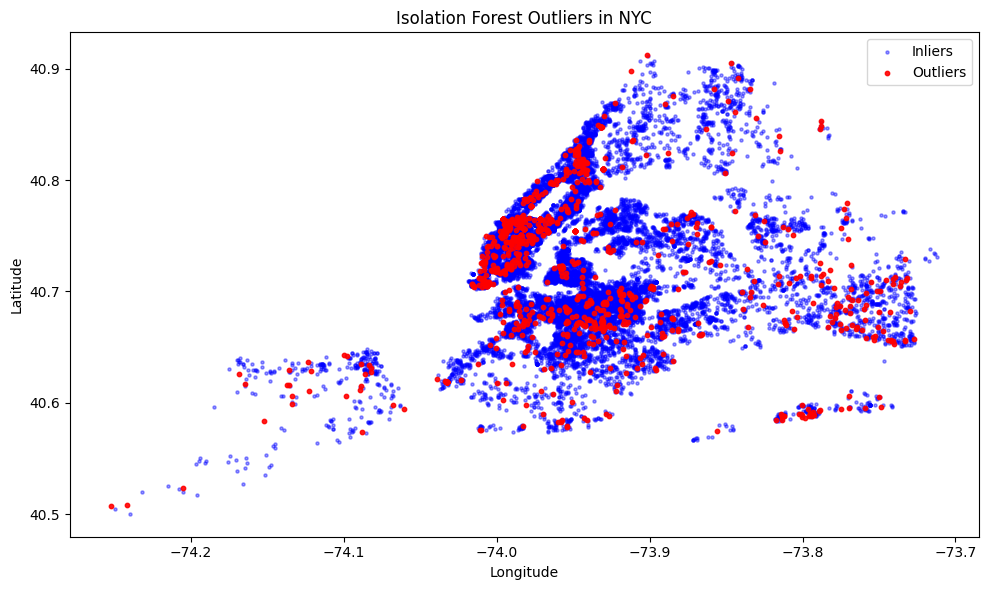

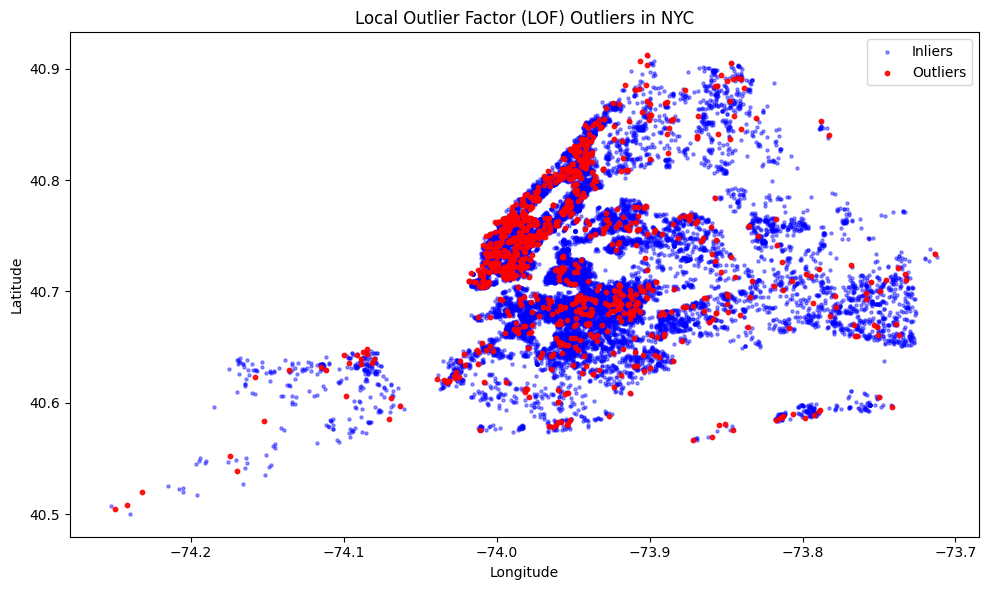

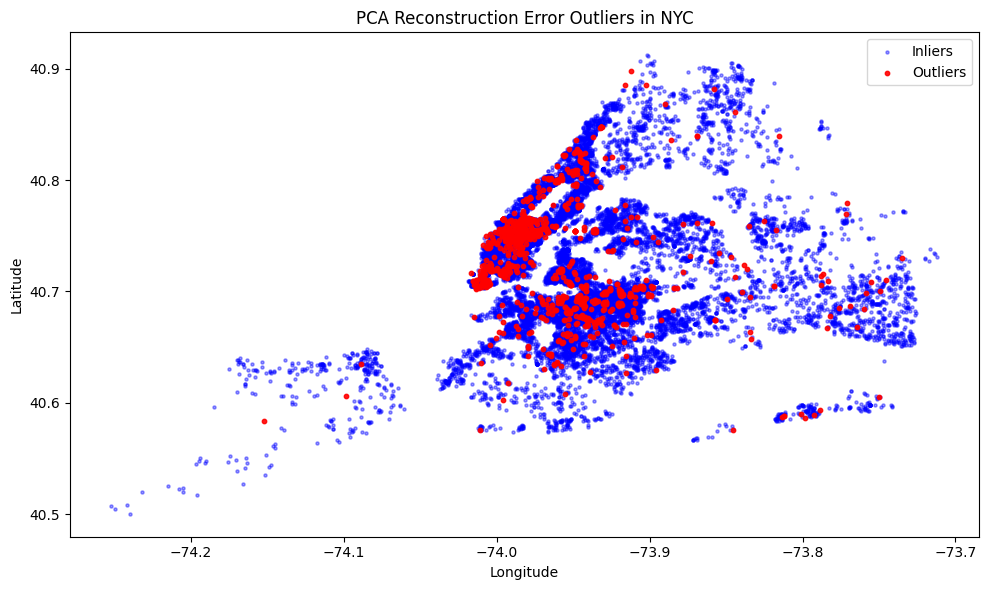


=== IsolationForest ===
Outlier count: 1067
Mean price (outliers): 8241.105904404874
Mean price (non-outliers): 282.3659246828883
accommodates (out vs in): 6.386129334582943 2.6827402398697004
availability_365 (out vs in): 244.98406747891283 251.36325946399486
number_of_reviews (out vs in): 103.76382380506092 33.13064508168402

=== LOF ===
Outlier count: 1067
Mean price (outliers): 1467.5716963448922
Mean price (non-outliers): 639.0788707368837
accommodates (out vs in): 2.879100281162137 2.867430038004047
availability_365 (out vs in): 270.20899718837865 250.03484526923646
number_of_reviews (out vs in): 33.27272727272727 36.842900153003306

=== PCA Reconstruction Error ===
Outlier count: 1067
Mean price (outliers): 3333.974695407685
Mean price (non-outliers): 540.7889541483638
accommodates (out vs in): 3.6785379568884724 2.8253294506687725
availability_365 (out vs in): 288.69072164948454 249.0615468140763
number_of_reviews (out vs in): 48.524835988753516 36.039682147969
Final dataset s

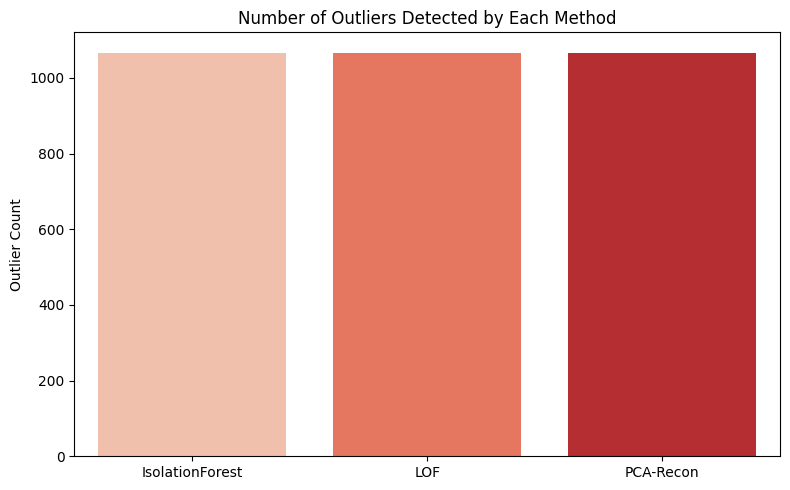

In [ ]:
# ============================================================
# TASK 3: Outlier Detection
# ============================================================

# --- 3.1 Isolation Forest ---
from IPython.display import display
iso = IsolationForest(
    n_estimators=200,
    contamination=0.05,
    random_state=42
)
iso_labels = iso.fit_predict(X_scaled)  # -1 = outlier, 1 = inlier

df_base["iso_outlier"] = iso_labels == -1
df_model["iso_outlier"] = df_base["iso_outlier"]

print("\nIsolationForest outlier counts:")
print(df_base["iso_outlier"].value_counts())

# --- 3.2 Local Outlier Factor (LOF) ---

lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.05
)
lof_labels = lof.fit_predict(X_scaled)  # -1 = outlier, 1 = inlier

df_base["lof_outlier"] = lof_labels == -1
df_model["lof_outlier"] = df_base["lof_outlier"]

print("\nLOF outlier counts:")
print(df_base["lof_outlier"].value_counts())
len(df_base)

# --- 3.3 PCA reconstruction error ---

pca_k = PCA(n_components=min(10, X_scaled.shape[1]))
X_pca_k = pca_k.fit_transform(X_scaled)
X_recon = pca_k.inverse_transform(X_pca_k)
recon_error = np.mean((X_scaled - X_recon) ** 2, axis=1)

df_base["pca_recon_error"] = recon_error
df_model["pca_recon_error"] = recon_error

threshold = np.percentile(recon_error, 95)
df_base["pca_outlier"] = df_base["pca_recon_error"] > threshold
df_model["pca_outlier"] = df_base["pca_outlier"]

print("\nPCA reconstruction outlier counts:")
print(df_base["pca_outlier"].value_counts())

# --- 3.4 Geographic maps of outliers ---

def make_outlier_map(df_all, mask_outliers):
    m = folium.Map(
        location=[df_all["latitude"].mean(), df_all["longitude"].mean()],
        zoom_start=11,
    )
    # Plot inliers (light gray)
    inliers = df_all[~mask_outliers].sample(
        n=min(2000, (~mask_outliers).sum()), random_state=42
    )
    for _, row in inliers.iterrows():
        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=2,
            color="gray",
            fill=True,
            fill_opacity=0.2,
        ).add_to(m)
    # Plot outliers (red)
    for _, row in df_all[mask_outliers].iterrows():
        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=4,
            color="red",
            fill=True,
            fill_opacity=0.8,
        ).add_to(m)
    return m

map_iso = make_outlier_map(df_base, df_base["iso_outlier"])
map_lof = make_outlier_map(df_base, df_base["lof_outlier"])
map_pca_out = make_outlier_map(df_base, df_base["pca_outlier"])

display(map_iso)
# ============================================================
# STATIC OUTLIER SCATTER MAPS (Isolation Forest, LOF, PCA Outliers)
# ============================================================

plt.figure(figsize=(10,6))
plt.scatter(df_base[~df_base["iso_outlier"]]["longitude"],
            df_base[~df_base["iso_outlier"]]["latitude"],
            s=5, color="blue", alpha=0.4, label="Inliers")
plt.scatter(df_base[df_base["iso_outlier"]]["longitude"],
            df_base[df_base["iso_outlier"]]["latitude"],
            s=10, color="red", alpha=0.9, label="Outliers")
plt.title("Isolation Forest Outliers in NYC")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,6))
plt.scatter(df_base[~df_base["lof_outlier"]]["longitude"],
            df_base[~df_base["lof_outlier"]]["latitude"],
            s=5, color="blue", alpha=0.4, label="Inliers")
plt.scatter(df_base[df_base["lof_outlier"]]["longitude"],
            df_base[df_base["lof_outlier"]]["latitude"],
            s=10, color="red", alpha=0.9, label="Outliers")
plt.title("Local Outlier Factor (LOF) Outliers in NYC")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,6))
plt.scatter(df_base[~df_base["pca_outlier"]]["longitude"],
            df_base[~df_base["pca_outlier"]]["latitude"],
            s=5, color="blue", alpha=0.4, label="Inliers")
plt.scatter(df_base[df_base["pca_outlier"]]["longitude"],
            df_base[df_base["pca_outlier"]]["latitude"],
            s=10, color="red", alpha=0.9, label="Outliers")
plt.title("PCA Reconstruction Error Outliers in NYC")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.tight_layout()
plt.show()



# --- 3.5 Outlier characterization ---

def describe_outliers(df_all, mask, label):
    print(f"\n=== {label} ===")
    print("Outlier count:", mask.sum())
    print("Mean price (outliers):", df_all.loc[mask, 'price'].mean())
    print("Mean price (non-outliers):", df_all.loc[~mask, 'price'].mean())
    for col in ['accommodates', 'availability_365', 'number_of_reviews']:
        if col in df_all.columns:
            print(f"{col} (out vs in):",
                  df_all.loc[mask, col].mean(),
                  df_all.loc[~mask, col].mean())

describe_outliers(df_base, df_base['iso_outlier'], "IsolationForest")
describe_outliers(df_base, df_base['lof_outlier'], "LOF")
describe_outliers(df_base, df_base['pca_outlier'], "PCA Reconstruction Error")

print("Final dataset size:", len(df_base))

print("\nOutliers detected:")
print("Isolation Forest:", df_base["iso_outlier"].sum())
print("Local Outlier Factor:", df_base["lof_outlier"].sum())
print("PCA Reconstruction Error:", df_base["pca_outlier"].sum())

print("\nInliers remaining after removing any outlier method:",
      len(df_base) - (df_base["iso_outlier"] | df_base["lof_outlier"] | df_base["pca_outlier"]).sum())

plt.figure(figsize=(8,5))
methods = ['IsolationForest', 'LOF', 'PCA-Recon']
counts = [
    df_base['iso_outlier'].sum(),
    df_base['lof_outlier'].sum(),
    df_base['pca_outlier'].sum()
]

sns.barplot(x=methods,hue= methods, legend= False, y=counts, palette="Reds")
plt.title("Number of Outliers Detected by Each Method")
plt.ylabel("Outlier Count")
plt.tight_layout()
plt.show()




Price category distribution:
price_cat
luxury    7175
mid       7082
budget    7071
Name: count, dtype: int64

=== Random Forest on Original Features ===
[[1347    0   67]
 [   3 1353   79]
 [  23   24 1370]]
              precision    recall  f1-score   support

      budget       0.98      0.95      0.97      1414
      luxury       0.98      0.94      0.96      1435
         mid       0.90      0.97      0.93      1417

    accuracy                           0.95      4266
   macro avg       0.96      0.95      0.95      4266
weighted avg       0.96      0.95      0.95      4266


Number of PCs explaining 95% variance: 13

=== Random Forest on PCA Features ===
[[1148   22  244]
 [  37 1117  281]
 [ 262  220  935]]
              precision    recall  f1-score   support

      budget       0.79      0.81      0.80      1414
      luxury       0.82      0.78      0.80      1435
         mid       0.64      0.66      0.65      1417

    accuracy                           0.75      4266


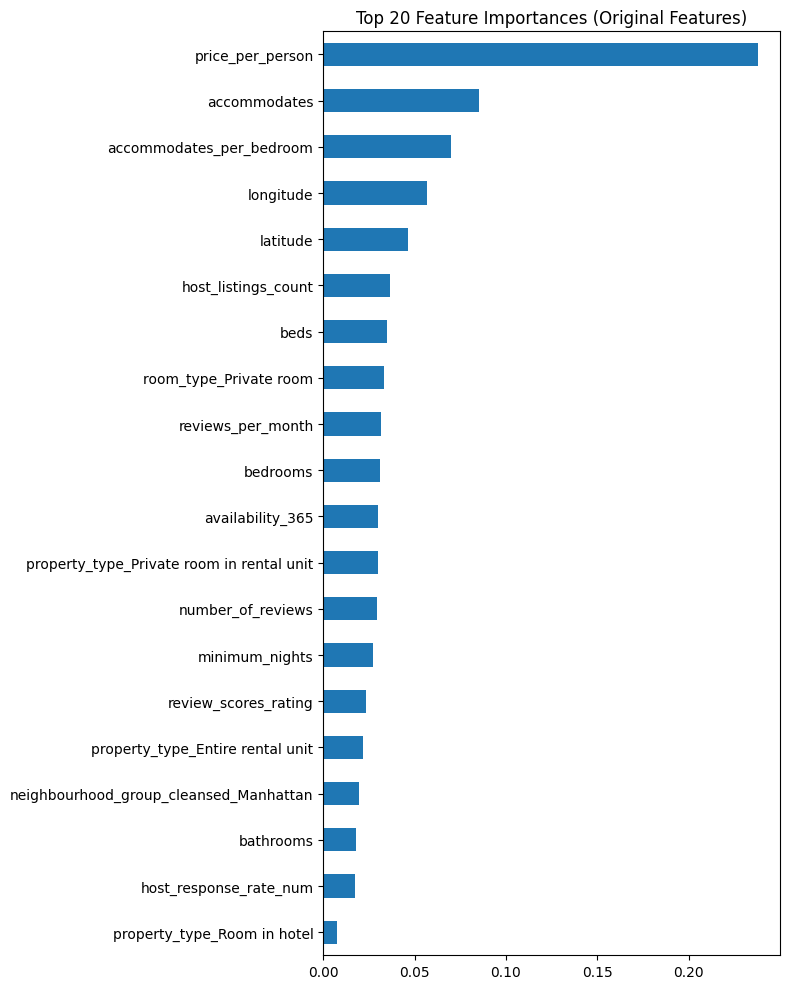

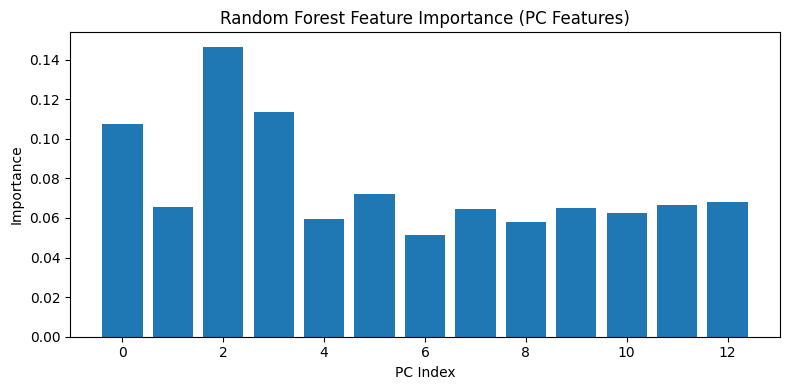

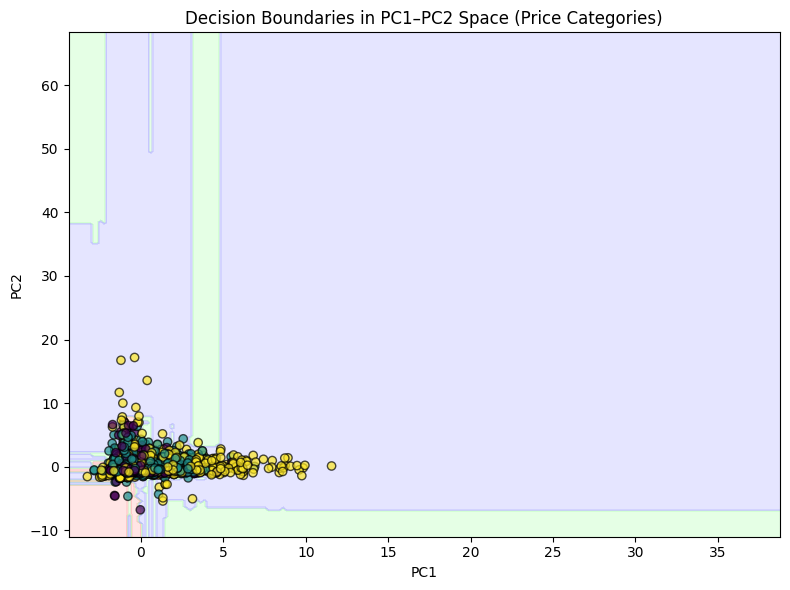

In [ ]:
# --- 4.1 Create price categories ---

price_series = df_base['price'].clip(lower=10)  # guard against near-zero/odd prices

df_base['price_cat'] = pd.qcut(
    price_series,
    q=[0, 0.33, 0.66, 1.0],
    labels=['budget', 'mid', 'luxury']
)

df_model['price_cat'] = df_base['price_cat']

print("\nPrice category distribution:")
print(df_base['price_cat'].value_counts())

# --- 4.2 Random Forest on original (engineered + dummies) features ---

target = df_model['price_cat']

feature_cols_original = [
    c for c in df_model.columns
    if c not in [
        'price', 'price_cat',
        'iso_outlier', 'lof_outlier',
        'pca_outlier', 'pca_recon_error'
    ]
]

X_orig = df_model[feature_cols_original]
y = target

X_train_orig, X_test_orig, y_train, y_test = train_test_split(
    X_orig, y, test_size=0.2, random_state=42, stratify=y
)

rf_orig = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)
rf_orig.fit(X_train_orig, y_train)

y_pred_orig = rf_orig.predict(X_test_orig)

print("\n=== Random Forest on Original Features ===")
print(confusion_matrix(y_test, y_pred_orig))
print(classification_report(y_test, y_pred_orig))

# --- 4.3 Random Forest on PCA features (95% variance) ---

pca_full = PCA(n_components=0.95)
X_pc = pca_full.fit_transform(X_scaled)  # same row order as df_base / df_model

print("\nNumber of PCs explaining 95% variance:", X_pc.shape[1])

X_train_pc, X_test_pc, y_train_pc, y_test_pc = train_test_split(
    X_pc, y, test_size=0.2, random_state=42, stratify=y
)

rf_pc = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)
rf_pc.fit(X_train_pc, y_train_pc)

y_pred_pc = rf_pc.predict(X_test_pc)

print("\n=== Random Forest on PCA Features ===")
print(confusion_matrix(y_test_pc, y_pred_pc))
print(classification_report(y_test_pc, y_pred_pc))

# --- 4.4 Effect of outlier removal (original features) ---

outlier_any = df_model['iso_outlier'] | df_model['lof_outlier'] | df_model['pca_outlier']
df_inliers = df_model[~outlier_any].copy()
print("\nTotal rows:", len(df_model), "Inliers (no method flagged):", len(df_inliers))

X_inliers_orig = df_inliers[feature_cols_original]
y_inliers = df_inliers['price_cat']

X_train_in, X_test_in, y_train_in, y_test_in = train_test_split(
    X_inliers_orig, y_inliers, test_size=0.2, random_state=42, stratify=y_inliers
)

rf_inliers = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)
rf_inliers.fit(X_train_in, y_train_in)

y_pred_in = rf_inliers.predict(X_test_in)

print("\n=== Random Forest on Original Features (Inliers Only) ===")
print(confusion_matrix(y_test_in, y_pred_in))
print(classification_report(y_test_in, y_pred_in))

# --- 4.5 Feature importance (original features) ---

importances = rf_orig.feature_importances_
feat_imp = pd.Series(importances, index=feature_cols_original).sort_values(ascending=False)

plt.figure(figsize=(8, 10))
feat_imp.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (Original Features)")
plt.tight_layout()
plt.show()

# --- 4.6 Feature importance (PC-based model) ---

pc_importances = rf_pc.feature_importances_

plt.figure(figsize=(8, 4))
plt.bar(range(len(pc_importances)), pc_importances)
plt.xlabel("PC Index")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importance (PC Features)")
plt.tight_layout()
plt.show()

# --- 4.7 Decision boundaries in PC1–PC2 space ---

pca_2_db = PCA(n_components=2)
X_2 = pca_2_db.fit_transform(X_scaled)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_2, y, test_size=0.2, random_state=42, stratify=y
)

rf_2 = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42
)
rf_2.fit(X_train_2, y_train_2)

# Build grid
x_min, x_max = X_2[:, 0].min() - 1, X_2[:, 0].max() + 1
y_min, y_max = X_2[:, 1].min() - 1, X_2[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

Z = rf_2.predict(np.c_[xx.ravel(), yy.ravel()])

# Map string categories to numerical codes for plotting
category_to_code = {cat: code for code, cat in enumerate(y.cat.categories)}
Z_numeric = np.array([category_to_code[cat] for cat in Z.ravel()]).reshape(xx.shape)

from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_numeric, alpha=0.3, cmap=cmap_light)

# Scatter test points
scatter = plt.scatter(X_test_2[:, 0], X_test_2[:, 1],
                      c=y_test_2.cat.codes, edgecolor='k', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Decision Boundaries in PC1–PC2 Space (Price Categories)")
plt.tight_layout()
plt.show()